In [1]:
import plotly.express as px
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2 # For image operations
import random # for shuffling
from matplotlib import pyplot as plt, cm
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

In [2]:
!pip install -q kaggle

!pip install imblearn # install imblearn library for data balancing

In [3]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d meetnagadia/kvasir-dataset  # Download the dataset
!unzip -q kvasir-dataset.zip -d dataset

100% 1.15G/1.15G [00:18<00:00, 114MB/s]
100% 1.15G/1.15G [00:18<00:00, 65.9MB/s]


In [6]:
dataset_path = 'dataset/kvasir-dataset'
classes = ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis',
           'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']

In [7]:
class_images = {class_name: [] for class_name in classes}

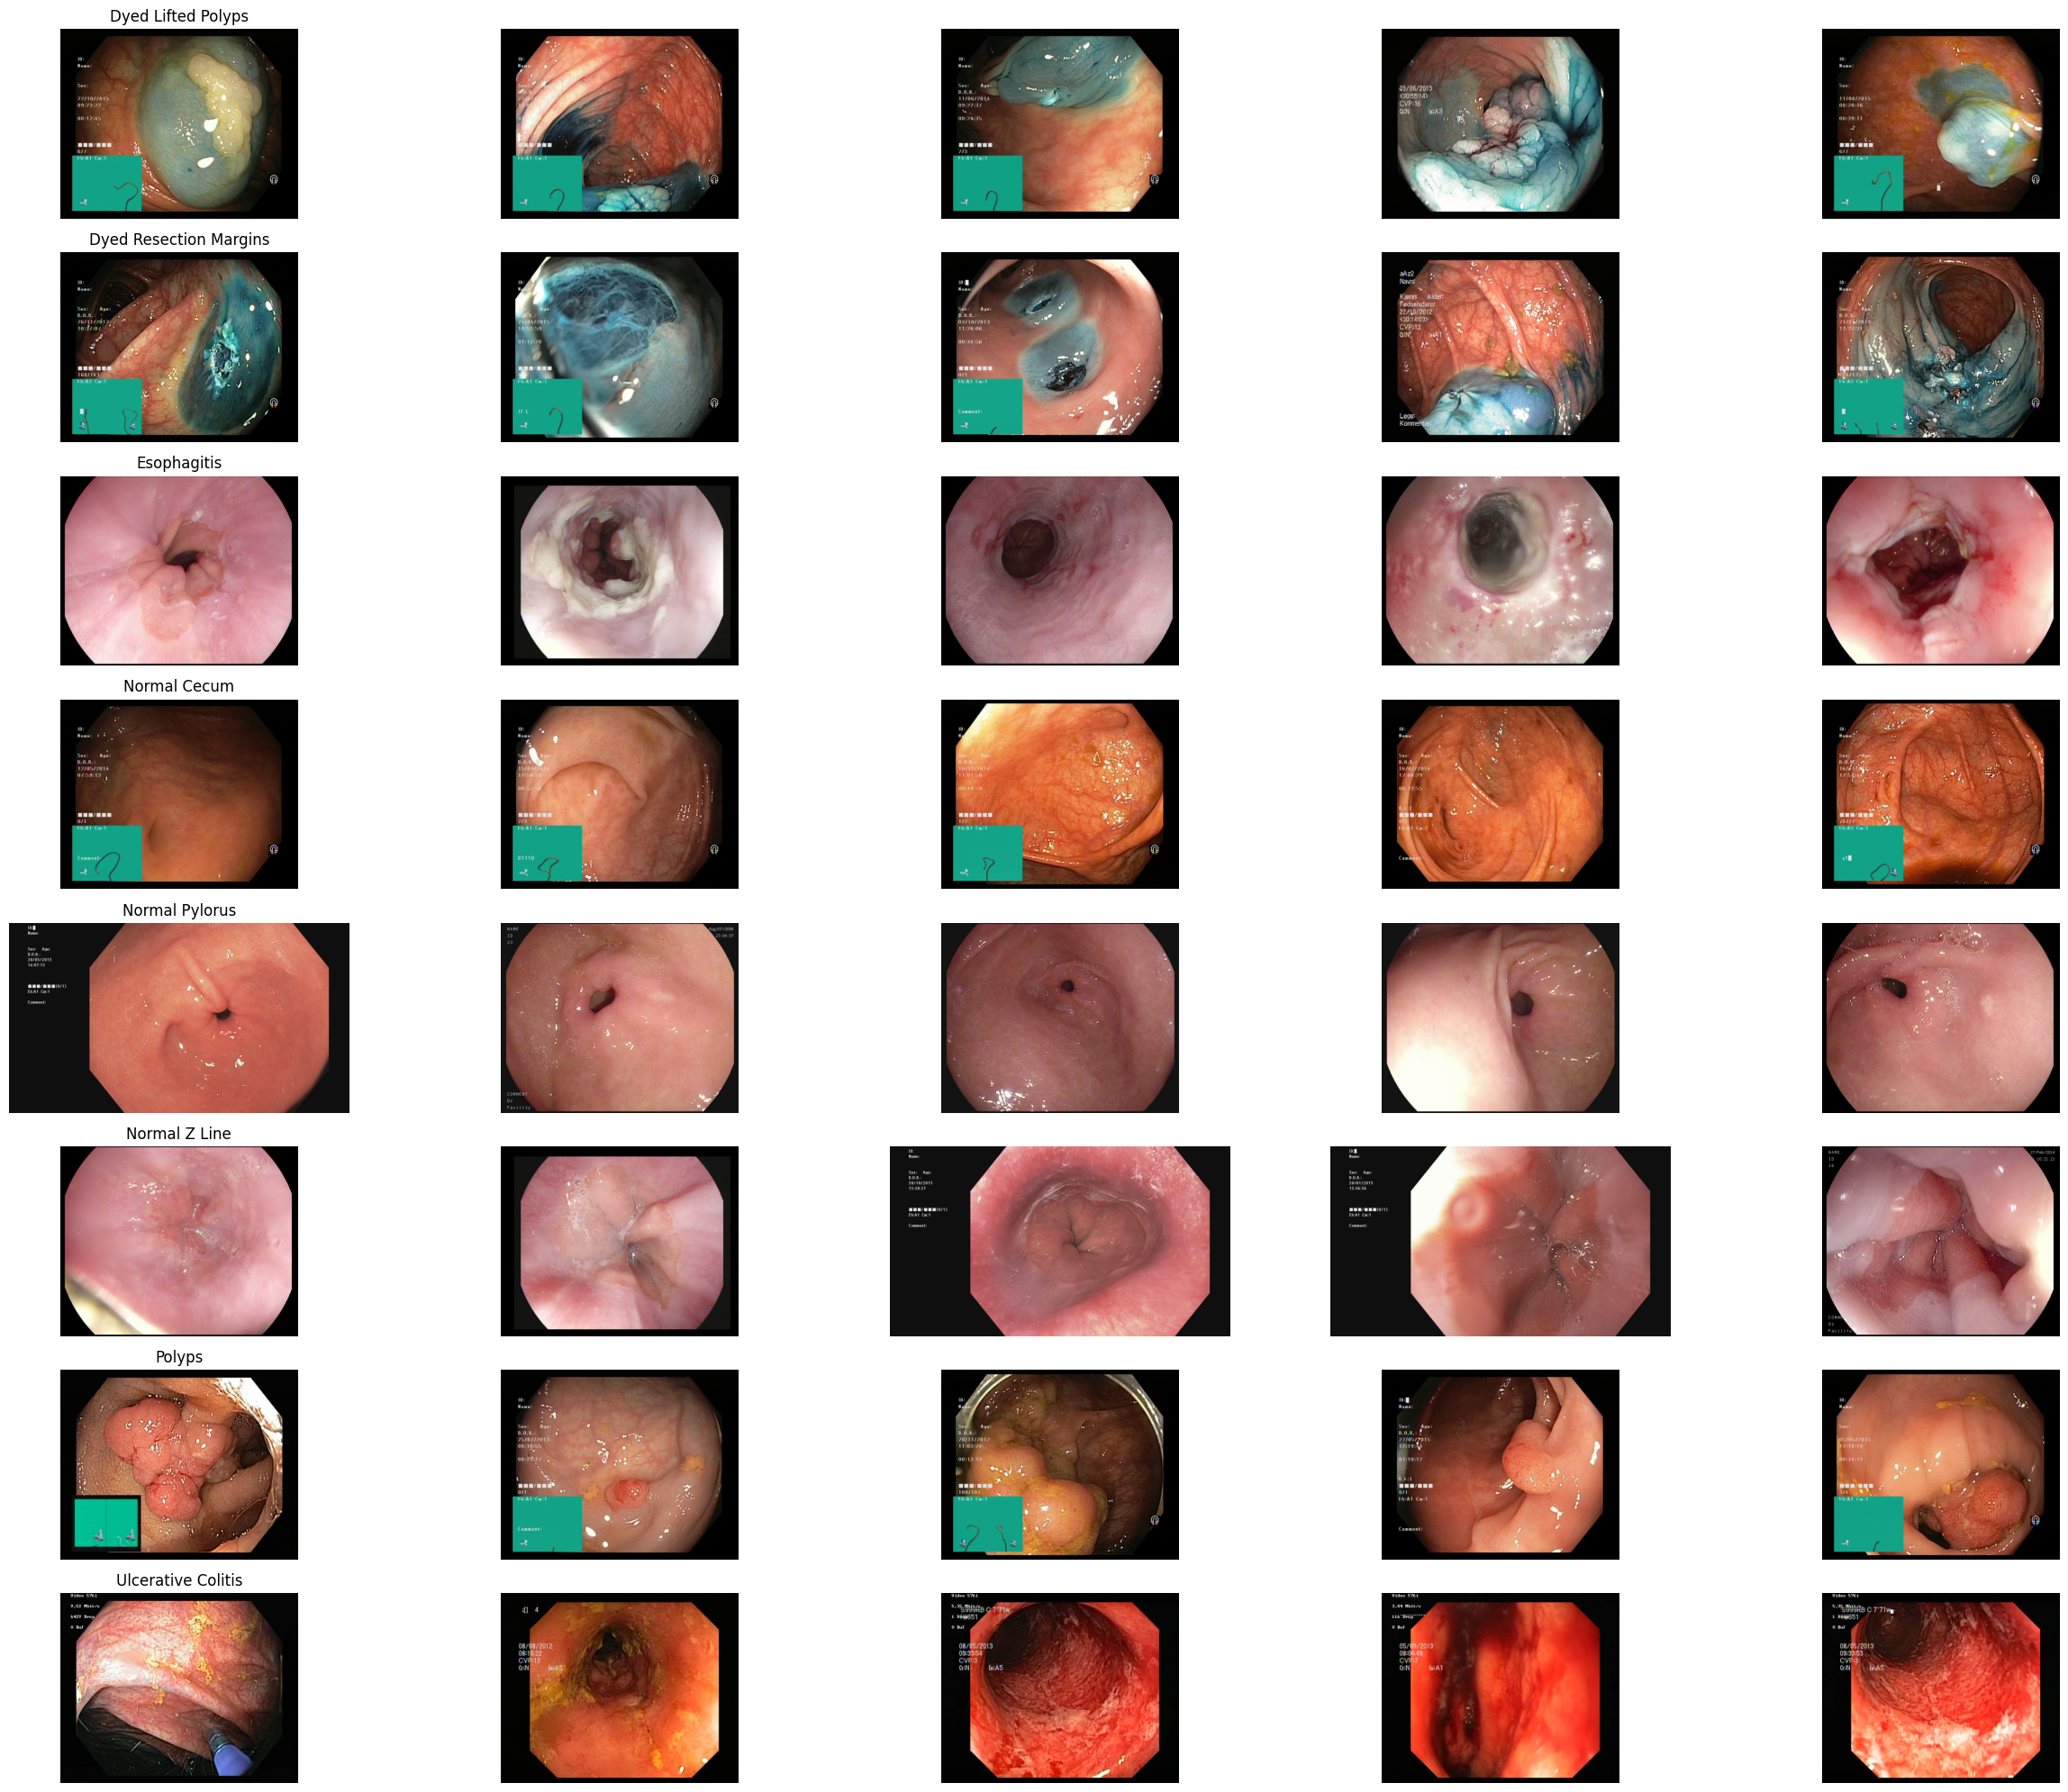

In [8]:
images_per_class = 5

# Number of classes
number_of_classes = 8

# Assuming the class directories are named as such:
class_names = [
    'dyed-lifted-polyps',
    'dyed-resection-margins',
    'esophagitis',
    'normal-cecum',
    'normal-pylorus',
    'normal-z-line',
    'polyps',
    'ulcerative-colitis'
]

# Set the size of the figure
plt.figure(figsize=(25, 20))

# Loop over each class
for i, class_name in enumerate(class_names):
    # Get the list of image files for the current class
    class_dir = os.path.join(dataset_path, class_name)
    image_files = [os.path.join(class_dir, img) for img in os.listdir(class_dir)[:images_per_class]]

    # Loop over each image file (limiting to the first `images_per_class`)
    for j, img_path in enumerate(image_files):
        # Load the image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert color to RGB

        # Plot the image
        plt.subplot(number_of_classes, images_per_class, i*images_per_class + j + 1)
        plt.imshow(img)
        plt.axis('off')  # Hide the axis
        if j == 0:
            plt.title(class_name.replace('-', ' ').title())  # Set the title for the first image in each row

# Show the plot
plt.tight_layout()
plt.show()

As we can see there are differences found between the different diseases found inside the intestinal tract,
The images present are of different size , so resizing  the images is important.

Since we are seeing different patterns , normalising the image using standard normalisation factor for color.(255.0)

In [9]:
def load_images_from_folder(class_name, n=400, image_size=(150, 150)):
    folder_path = os.path.join(dataset_path, class_name)
    images = []
    # Get the list of image file names
    filenames = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path)]
    # Load the images
    for filename in tqdm(filenames[:n], desc=f'Loading {class_name}'):
        img = cv2.imread(filename)  # By default, OpenCV reads images in BGR format
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB format
        img = cv2.resize(img, image_size)
        img = img / 255.0  # Normalizing the image
        images.append(img)  # Do not flatten
    return images

In [10]:
for class_name in classes:
    class_images[class_name] = load_images_from_folder(class_name)

Loading ulcerative-colitis: 100%|██████████| 400/400 [00:04<00:00, 96.97it/s]


In [11]:
dyed_lifted_polyps = class_images['dyed-lifted-polyps']

In [12]:
len(dyed_lifted_polyps)

400

Each Class has 400 images loaded. Now defining each class into unique variable

In [13]:
dyed_resection_margins = class_images['dyed-resection-margins']
esophagitis=class_images['esophagitis']
normal_cecum=class_images['normal-cecum']
normal_pylorus=class_images['normal-pylorus']
normal_z_line=class_images['normal-z-line']
polyps=class_images['polyps']
ulcerative_colitis=class_images['ulcerative-colitis']

In [14]:
df = pd.DataFrame({
    'dataset': ['dyed_lifted_polyps', 'dyed_resection_margins', 'esophagitis', 'normal_cecum', 'normal_pylorus', 'normal_z_line', 'polyps', 'ulcerative_colitis'],
    'count_of_images': [len(dyed_lifted_polyps), len(dyed_resection_margins), len(esophagitis), len(normal_cecum), len(normal_pylorus), len(normal_z_line), len(polyps), len(ulcerative_colitis)]})

In [15]:
df

dataset  count_of_images
0      dyed_lifted_polyps              400
1  dyed_resection_margins              400
2             esophagitis              400
3            normal_cecum              400
4          normal_pylorus              400
5           normal_z_line              400
6                  polyps              400
7      ulcerative_colitis              400

In [16]:
fig = px.pie(df, values='count_of_images', names='dataset',
             color='dataset',
             color_discrete_sequence=px.colors.qualitative.Pastel,
             title='Distribution of Images Across Classes',
             hole=0.3)

fig.update_traces(textinfo='percent', showlegend=True)
fig.update_layout(legend_title_text='Gastro-Intestinal Diseases')

fig.show()

Creation of Dataset

In [17]:
np.random.seed(150) # Random seed to control the randomness of generated values
data = np.array(dyed_lifted_polyps + dyed_resection_margins + esophagitis + normal_cecum  + normal_pylorus + normal_z_line + polyps + ulcerative_colitis)  # Combining the list of images
labels = np.array([0]*400 + [1]*400 +[2]*400 +[3]*400 +[4]*400 +[5]*400 +[6]*400 +[7]*400) # creating class labels for the image classes
length = data.shape[0] # length of the data

# Shuffling the data and labels
indx = np.arange(length)
np.random.shuffle(indx)

data = data[indx]
labels = labels[indx]


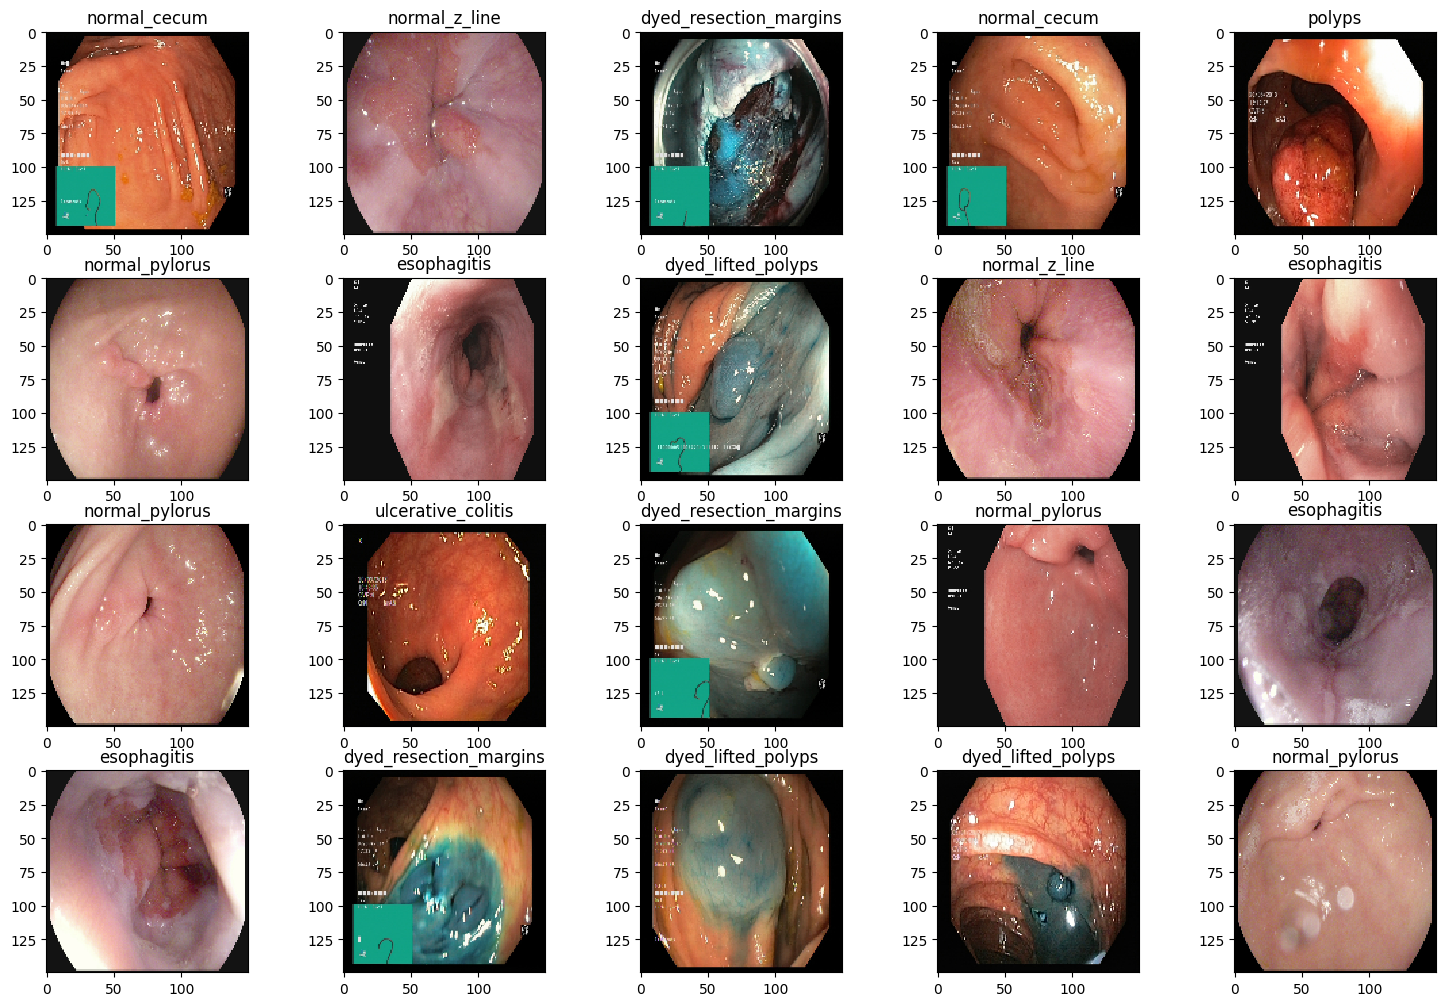

In [18]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 10))
fig.tight_layout() # add spacing between subplots
label = ['dyed_lifted_polyps', 'dyed_resection_margins', 'esophagitis', 'normal_cecum', 'normal_pylorus', 'normal_z_line', 'polyps', 'ulcerative_colitis']
for ax in axes.flat:
    y = np.random.randint(length)
    ax.imshow(np.asarray(data[y]), interpolation='nearest', cmap='gray')
    ax.set_title(label[labels[y]])

plt.show()

Train Test split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state=150, test_size=0.3, stratify=labels, shuffle=True)

Since the categories has class vectors we would be converting them to binary class matrices  using one-hot encoding

In [20]:
y_train_one = to_categorical(y_train)
y_test_one=to_categorical(y_test)

Now let us import the VGG16 Model from tensorflow libraries.

The archeitecture of VGG16 is given below:

- **16 Layers:** The "16" in VGG16 refers to it having 16 layers that have weights. This network contains 13 convolutional layers, 3 fully connected layers, and 5 MaxPooling layers.
- **Convolutional Layers:** The convolutional layers use 3x3 filters with a stride of 1 and are always followed by a ReLU activation function.
- **Max Pooling:** Max pooling is performed over a 2x2 pixel window, with stride 2.
- **Fully Connected Layers:** Three fully connected layers follow the convolutional layers. The first two have 4096 channels each, and the third performs 1000-way ILSVRC classification and thus contains 1000 channels (one for each class).
- **Final Layer:** The final layer is a softmax activation function that is used to output a distribution over the 1000 class labels.



In [21]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [22]:
# Load the base VGG16 model, pre-trained on ImageNet data
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [23]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')  #based on  dataset, there are 8 classes representing 8 different diseases
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 16814152 (64.14 MB)
Trainable params: 2099464 (8.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [25]:
model.compile(optimizer=Adam(lr=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
# Learning Rate Annealer
from keras.callbacks import ReduceLROnPlateau
lrr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.01, patience=3, min_lr=1e-5)

In [27]:
history = model.fit(X_train, y_train_one,
                    batch_size=32,
                    epochs=10,
                    validation_data=(X_test, y_test_one),
                    callbacks=[lrr])

Epoch 1/10
70/70 [==============================] - 723s 10s/step - loss: 1.2763 - accuracy: 0.5321 - val_loss: 0.6828 - val_accuracy: 0.7302 - lr: 0.0010
Epoch 2/10
70/70 [==============================] - 759s 11s/step - loss: 0.7595 - accuracy: 0.7027 - val_loss: 0.5792 - val_accuracy: 0.7729 - lr: 0.0010
Epoch 3/10
70/70 [==============================] - 757s 11s/step - loss: 0.6015 - accuracy: 0.7563 - val_loss: 0.5602 - val_accuracy: 0.7771 - lr: 0.0010
Epoch 4/10
70/70 [==============================] - 758s 11s/step - loss: 0.5639 - accuracy: 0.7799 - val_loss: 0.4677 - val_accuracy: 0.8260 - lr: 0.0010
Epoch 5/10
70/70 [==============================] - 760s 11s/step - loss: 0.4976 - accuracy: 0.8027 - val_loss: 0.4973 - val_accuracy: 0.8010 - lr: 0.0010
Epoch 6/10
70/70 [==============================] - 763s 11s/step - loss: 0.4553 - accuracy: 0.8308 - val_loss: 0.4672 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 7/10
70/70 [==============================] - 761s 11s/step - lo